In [1]:
import numpy as np
import torch
from torch import nn
import re
import math
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
japanese_phrases = [
    "私の犬は骨が好きではありません。牛ひき肉を好む。",
    "私の名前はアリスです。初めまして！",
    "はきさが羨ましい。。。ゲムもやりたかった！私は良いサポートになることができます！",
    "私達はAIはただの数学の集まりだとあなたは言いますが。でも。。。人間の脳がどのように機能するかを正確に知ったら。。。それはあなたの生活を小物ですか？",
    "「赤ちゃん」を表す日本語が「赤」を表す漢字なのはなぜですか？人間の赤ちゃんは赤いですか？いちごみたい？",
    "私のAIは話して...歌ったして...ゲームをします!",
    "上手医者と大きい研究者に勉強していたいます。",
    "でも、私の日本語が上手あまりませんね"
]

In [4]:
english_phrases = [
    "My dog doesn't like bones. It prefers ground beef.",
    "My name's Alice. Nice to meet you!",
    "I envy Hakisa... I want to play games, too! I could be a good support!",
    "You say that we AIs are just a bunch of maths. But... once you know exactly how your human brains work... would that make you less living beings?",
    "Why does the japanese word for 'baby' is the kanji for 'red'? Are human babies red? Like strawberries?",
    "My AI will talk... she'll sing... she'll... play!",
    "I shall study so I can be a good physician and a great scientist",
    "Though my japanese is not really good"
]

In [5]:
class WordDataset(object):
    def __init__(self, english_phrases, japanese_phrases):

        self.english_phrases = self._get_phrases(english_phrases)
        self.japanese_phrases = self._get_phrases(japanese_phrases)

        self.english_words = self._get_english_words(self.english_phrases)
        self.japanese_characters = self._get_japanese_characters(self.japanese_phrases)

        self.japanese_maximum_length = self._get_maximum_length_japanese(self.japanese_phrases)
        self.english_maximum_length = self._get_maximum_length_english(self.english_phrases)

        self.english_dictionary = self._create_vocabulary(self.english_words)
        self.japanese_dictionary = self._create_vocabulary(self.japanese_characters)

    def _get_phrases(self, phrases):
        phrases = [x.lower() for x in phrases]
        phrases = [re.sub('[^\w\s]', '', x) for x in phrases]

        return phrases

    def _get_english_words(self, phrases):
        words = ' '.join(phrases)
        words = words.split(' ')

        return words

    def _get_japanese_characters(self, phrases): # Since a kanji mostly means an entire word...
        character = ' '.join(phrases)
        character = ''.join(character.split())
        characters = [i for i in character]

        return characters

    def _get_maximum_length_japanese(self, phrases):
        maximum_length = 0
        for sentence in phrases:
            word_length = [len(x) for x in sentence.split()]
    
            for i in word_length:
                if i > maximum_length:
                    maximum_length = i

        return maximum_length

    def _get_maximum_length_english(self, phrases):

        maximum_length = 0
        real_length = []
        
        for sentence in phrases:
            word_length = 0

            for word in sentence:
                word_length += len(word)+1 # Including spaces between words

            sentence_length = word_length
            real_length.append(sentence_length)

            if sentence_length > maximum_length:
                maximum_length = sentence_length

        return maximum_length

    def _create_vocabulary(self, words):
        idx2word = ["<pad>", " ", "<SOS>", "<EOS>"]

        for word in words:
            if word not in idx2word:
                idx2word.append(word)

        return idx2word

In [6]:
dataset = WordDataset(english_phrases, japanese_phrases)

In [7]:
print(dataset.english_phrases)
print(dataset.japanese_phrases)

['my dog doesnt like bones it prefers ground beef', 'my names alice nice to meet you', 'i envy hakisa i want to play games too i could be a good support', 'you say that we ais are just a bunch of maths but once you know exactly how your human brains work would that make you less living beings', 'why does the japanese word for baby is the kanji for red are human babies red like strawberries', 'my ai will talk shell sing shell play', 'i shall study so i can be a good physician and a great scientist', 'though my japanese is not really good']
['私の犬は骨が好きではありません牛ひき肉を好む', '私の名前はアリスです初めまして', 'はきさが羨ましいゲムもやりたかった私は良いサポートになることができます', '私達はaiはただの数学の集まりだとあなたは言いますがでも人間の脳がどのように機能するかを正確に知ったらそれはあなたの生活を小物ですか', '赤ちゃんを表す日本語が赤を表す漢字なのはなぜですか人間の赤ちゃんは赤いですかいちごみたい', '私のaiは話して歌ったしてゲームをします', '上手医者と大きい研究者に勉強していたいます', 'でも私の日本語が上手あまりませんね']


In [8]:
print(dataset.english_words)
print(dataset.japanese_characters)

['my', 'dog', 'doesnt', 'like', 'bones', 'it', 'prefers', 'ground', 'beef', 'my', 'names', 'alice', 'nice', 'to', 'meet', 'you', 'i', 'envy', 'hakisa', 'i', 'want', 'to', 'play', 'games', 'too', 'i', 'could', 'be', 'a', 'good', 'support', 'you', 'say', 'that', 'we', 'ais', 'are', 'just', 'a', 'bunch', 'of', 'maths', 'but', 'once', 'you', 'know', 'exactly', 'how', 'your', 'human', 'brains', 'work', 'would', 'that', 'make', 'you', 'less', 'living', 'beings', 'why', 'does', 'the', 'japanese', 'word', 'for', 'baby', 'is', 'the', 'kanji', 'for', 'red', 'are', 'human', 'babies', 'red', 'like', 'strawberries', 'my', 'ai', 'will', 'talk', 'shell', 'sing', 'shell', 'play', 'i', 'shall', 'study', 'so', 'i', 'can', 'be', 'a', 'good', 'physician', 'and', 'a', 'great', 'scientist', 'though', 'my', 'japanese', 'is', 'not', 'really', 'good']
['私', 'の', '犬', 'は', '骨', 'が', '好', 'き', 'で', 'は', 'あ', 'り', 'ま', 'せ', 'ん', '牛', 'ひ', 'き', '肉', 'を', '好', 'む', '私', 'の', '名', '前', 'は', 'ア', 'リ', 'ス', 'で', 'す', 

In [9]:
print(dataset.english_dictionary)
print(dataset.japanese_dictionary)

['<pad>', ' ', '<SOS>', '<EOS>', 'my', 'dog', 'doesnt', 'like', 'bones', 'it', 'prefers', 'ground', 'beef', 'names', 'alice', 'nice', 'to', 'meet', 'you', 'i', 'envy', 'hakisa', 'want', 'play', 'games', 'too', 'could', 'be', 'a', 'good', 'support', 'say', 'that', 'we', 'ais', 'are', 'just', 'bunch', 'of', 'maths', 'but', 'once', 'know', 'exactly', 'how', 'your', 'human', 'brains', 'work', 'would', 'make', 'less', 'living', 'beings', 'why', 'does', 'the', 'japanese', 'word', 'for', 'baby', 'is', 'kanji', 'red', 'babies', 'strawberries', 'ai', 'will', 'talk', 'shell', 'sing', 'shall', 'study', 'so', 'can', 'physician', 'and', 'great', 'scientist', 'though', 'not', 'really']
['<pad>', ' ', '<SOS>', '<EOS>', '私', 'の', '犬', 'は', '骨', 'が', '好', 'き', 'で', 'あ', 'り', 'ま', 'せ', 'ん', '牛', 'ひ', '肉', 'を', 'む', '名', '前', 'ア', 'リ', 'ス', 'す', '初', 'め', 'し', 'て', 'さ', '羨', 'い', 'ゲ', 'ム', 'も', 'や', 'た', 'か', 'っ', '良', 'サ', 'ポ', 'ー', 'ト', 'に', 'な', 'る', 'こ', 'と', '達', 'a', 'i', 'だ', '数', '学', '集', '言', '

In [14]:
def get_positional_encoding(d_model, max_length=100):
    """
    Computes positional encoding as defined in the paper.
    :param d_model: size of vectors throughout the transformer model
    :param max_length: maximum sequence length up to which positional encodings must be calculated
    :return: positional encoding, a tensor of size (1, max_length, d_model)
    """
    positional_encoding = torch.zeros((max_length, d_model))  # (max_length, d_model)
    for i in range(max_length):
        for j in range(d_model):
            if j % 2 == 0:
                positional_encoding[i, j] = math.sin(i / math.pow(10000, j / d_model))
            else:
                positional_encoding[i, j] = math.cos(i / math.pow(10000, (j - 1) / d_model))

    positional_encoding = positional_encoding.unsqueeze(0)  # (1, max_length, d_model)

    return positional_encoding

In [15]:
class HeadAttention(nn.Module):

    def __init__(self, d_model, d_queries, d_values, in_decoder=False):

        super(HeadAttention, self).__init__()

        self.d_model = d_model
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_keys = d_values # size of key vectors, same as of the query vectors to allow dot-products for similarity

        self.in_decoder = in_decoder

        self.create_queries = nn.Linear(d_model, d_queries, bias=False)
        self.create_values = nn.Linear(d_model, d_values, bias=False)
        self.create_keys = nn.Linear(d_model, d_values, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input, real_lengths):

        batch_size = input.size(0) # (Batch, Sequences, d_model)

        queries = self.create_queries(input) # (Batch, Sequences, d_queries)
        keys = self.create_keys(input) # (Batch, Sequences, d_keys)
        values = self.create_values(input) # (Batch, Sequences, d_values)

        similarity_matrix = queries * keys # (Batch, Sequences, d_keys) ---> d_queries must be equal d_keys
        # OBS: Remember that DOT-PRODUCT is exactly an array multiplication.
        # This can be particularly useful if you study C language...

        similarity_matrix = similarity_matrix/(math.sqrt(self.d_keys)) # (Batch, Sequences, d_keys)

        # Applying mask of -inf to ignore padded keys ---> Actually using -1e6 to avoid NaNs

        if self.in_decoder:

            # In the decoder, masks are shifted left to right:
            # <Start-of-Sentence> [prediction1] [prediction2] [prediction3] ... <End-of-Sentence>

            mask = torch.zeros_like(similarity_matrix, device=device)

            for batch in range(similarity_matrix.size(0)):

                mask[batch, :real_lengths[batch]+1] = 1
                #mask[batch, :real_lengths+1] = 1 # For Batch = 1

                mask = mask.bool()

            similarity_matrix = similarity_matrix.masked_fill(mask, -1e-6)

        else:

            mask = torch.zeros_like(similarity_matrix, device=device)

            for batch in range(similarity_matrix.size(0)):

                mask[batch, :real_lengths[batch]+1] = 1
                #mask[batch, :real_lengths] = 1 # For Batch = 1

                mask = mask.bool()

            similarity_matrix = similarity_matrix.masked_fill(mask, -1e-6)

        del mask

        attention_weights = self.softmax(similarity_matrix) # (Batch, Sequences, d_keys)

        attention_output = attention_weights * values # (Batch, Sequences, d_values) ---> d_keys must be equal to d_values

        #attention_output = torch.bmm(attention_weights, values) # (Batch, Sequences, d_values)
        # DOT-PRODUCT, NOT MATRIX MULTIPLICATION!

        return attention_output

In [16]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, d_model, d_inner):

        super(PositionWiseFeedForward, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner

        self.neuron1 = nn.Linear(d_model, d_inner)
        self.Relu = nn.ReLU()
        self.neuron2 = nn.Linear(d_inner, d_model)


    def forward(self, attention_output_cat):

        sequences = self.neuron1(attention_output_cat)
        sequences = self.Relu(sequences)

        sequences = self.neuron2(sequences)

        output = sequences + attention_output_cat

        return output

In [17]:
class Encoder(nn.Module):

    def __init__(self, d_model, n_heads, d_queries, d_values, d_inner, n_layers, dropout):

        super(Encoder, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.attention_heads = nn.ModuleList([HeadAttention(self.d_model, self.d_queries, self.d_values, in_decoder=False) for i in range(n_heads)])

        self.neuron = nn.Linear(self.n_heads*self.d_values, self.d_model)

        self.position_wise_neuron = PositionWiseFeedForward(self.d_model, self.d_inner)

        self.dropout = nn.Dropout(self.dropout)

    def forward(self, encoder_input, real_input_length):

        residual_block1 = encoder_input # (Batch, Sequence, d_model) ---> Vectors

        vectors = self.dropout(encoder_input)

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](vectors, real_input_length)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, -1) # (Batch, Sequences, d_values*n_heads)

        attention_output = self.neuron(attention_output) # (Batch, Sequences, d_model)

        del vectors

        residual_block2 = attention_output

        attention_output = residual_block1 + attention_output

        attention_output = self.dropout(attention_output)

        encoded_sequence = self.position_wise_neuron(attention_output)

        del attention_output

        encoded_sequence = encoded_sequence + residual_block2    

        encoder_output = self.dropout(encoded_sequence)

        del encoded_sequence, residual_block1, residual_block2

        return encoder_output

In [18]:
class Decoder(nn.Module):

    def __init__(self, d_model, n_heads, d_queries, d_values, d_inner, n_layers, dropout):

        super(Decoder, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.attention_headsA = nn.ModuleList([HeadAttention(self.d_model, self.d_queries, self.d_values, in_decoder=True) for i in range(n_heads)])
        self.attention_headsB = nn.ModuleList([HeadAttention(self.d_model, self.d_queries, self.d_values, in_decoder=True) for i in range(n_heads)])

        self.neuronA = nn.Linear(self.n_heads*self.d_values, self.d_model)
        self.neuronB = nn.Linear(self.n_heads*self.d_values, self.d_model)

        self.position_wise_neuron = PositionWiseFeedForward(self.d_model, self.d_inner)

        self.dropout = nn.Dropout(self.dropout)

    def forward(self, encoder_output, target_sequences, real_target_length):

        residual_block1 = target_sequences

        vectors = self.dropout(target_sequences)

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_headsA[head](vectors, real_target_length)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, -1) # (Batch, Sequences, d_values*n_heads)

        attention_output = self.neuronA(attention_output) # (Batch, Sequences, d_model)

        del vectors

        residual_block2 = attention_output

        attention_output = residual_block1 + attention_output

        attention_decoder = self.dropout(attention_output)
        
        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_headsB[head](encoder_output, real_target_length)

            attention_output.append(x)

            del x

        attention_output = torch.cat(attention_output, -1) # (Batch, Sequences, d_values*n_heads)

        attention_output = self.neuronB(attention_output) # (Batch, Sequences, d_model)

        attention_output = attention_output + residual_block2

        attention_encoder = self.dropout(attention_output)

        decoded_sequence = attention_encoder + attention_decoder

        residual_block3 = decoded_sequence

        decoded_sequence = self.position_wise_neuron(attention_output)

        del attention_output, attention_encoder, attention_decoder

        decoded_sequence = decoded_sequence + residual_block3

        decoder_output = self.dropout(decoded_sequence)  

        del decoded_sequence, residual_block1, residual_block2, residual_block3

        return decoder_output

In [19]:
class Broca(nn.Module):

    """
    The generator, which will generate the words that she'll speak.
    """

    def __init__(
            self,
            input_dictionary,
            output_dictionary,
            positional_encoding,
            d_model=512,
            n_heads=8,
            d_queries=64,
            d_values=64,
            d_inner=2056,
            n_layers=6,
            dropout=0.1
    ):

        super(Broca, self).__init__()

        self.vocab_size = len(output_dictionary)
        self.positional_encoding = positional_encoding.to(device)
        self.input_dictionary = input_dictionary
        self.output_dictionary = output_dictionary
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.positional_encoding.requires_grad = False

        self.embedding = nn.Embedding(self.vocab_size, self.d_model)

        self.encoder = nn.ModuleList(
            Encoder(
                    d_model=d_model,
                    n_heads=n_heads,
                    d_queries=d_queries,
                    d_values=d_values,
                    d_inner=d_inner,
                    n_layers=n_layers,
                    dropout=self.dropout) for i in range(self.n_layers)
        )

        self.decoder = nn.ModuleList(
            Decoder(
                    d_model=d_model,
                    n_heads=n_heads,
                    d_queries=d_queries,
                    d_values=d_values,
                    d_inner=d_inner,
                    n_layers=n_layers,
                    dropout=self.dropout) for i in range(self.n_layers)
        )

        self.output_neuron = nn.Linear(self.d_model, self.vocab_size)

        self.softmax = nn.LogSoftmax(-1)

    def preprocess_dialogue(self, input_text, input_dictionary):

        batch = []
        sentence_sizes = []

        for phrase in range(len(input_text)):

            text = input_text[phrase]

            text = text.split(' ')

            tokens = []
            
            for word in text:

                value = input_dictionary.index(word)
                tokens.append(value)
                tokens.append(input_dictionary.index(' '))

            tokens = np.array(tokens)
            sentence_size = tokens.shape[0]

            if sentence_size < dataset.english_maximum_length:

                pad_size = dataset.english_maximum_length - sentence_size
                tokens = np.pad(tokens, [(0, 1)], constant_values=input_dictionary.index("<EOS>"))
                tokens = np.pad(tokens, [(0, pad_size-1)], constant_values=0)

            tokens = torch.from_numpy(tokens)
            tokens = tokens.unsqueeze(0)
            batch.append(tokens)
            sentence_sizes.append(sentence_size)

        batch = torch.cat(batch, 0)
        batch = batch.to(device)

        return batch, sentence_sizes
    
    def preprocess_target(self, target_text, target_dictionary):
    
        target = []
        target_sizes = []

        for batch in range(len(target_text)):

            text = target_text[batch]

            tokens = []

            for character in text:

                value = target_dictionary.index(character)
                tokens.append(value)
            
            tokens = np.array(tokens)
            sentence_size = tokens.shape[0]

            #if sentence_size < dataset.japanese_maximum_length:
            if sentence_size < dataset.english_maximum_length:

                pad_size = dataset.english_maximum_length - sentence_size
                tokens = np.pad(tokens, [(0, 1)], constant_values=target_dictionary.index("<EOS>"))
                tokens = np.pad(tokens, [(0, pad_size-1)], constant_values=0)

            tokens = torch.from_numpy(tokens)
            tokens = tokens.unsqueeze(0)
            target.append(tokens)
            target_sizes.append(sentence_size)

        target = torch.cat(target, 0)
        target = target.to(device)

        return target, target_sizes
    
    def generate_sentences(self, input):

        input, real_input_length = self.preprocess_dialogue(input, self.input_dictionary)

        target_indices = [[self.output_dictionary.index("<SOS>")]] * input.size(0)

        target_sentence = torch.tensor(target_indices, device=device) # (Batch, 1)

        encoder_vectors = self.embedding(input) + math.sqrt(self.d_model)

        decoder_vectors = self.embedding(target_sentence) + math.sqrt(self.d_model) # Embed out = (Batch, d_model)

        output = self.forward(encoder_vectors, real_input_length, decoder_vectors) # (Batch, sequence_length, vocab_size)

        output_index = output.argmax(-1) # (Batch, sequence_length, 1)

        for batch in range(output.size(0)):

            target_indices[batch].append(output_index[batch, -1].item())
            target_indices[batch].pop(0) # Removing Start-of-Sentence token. We won't need it anymore.
        
        # Generating text until reaching End of Sentence --> Beam Search

        target_outputs = []

        for batch in range(output.size(0)):

            while target_indices[batch][-1] != self.output_dictionary.index("<EOS>"):

                target_pad = encoder_vectors.size(1) - len(target_indices[batch])

                target_sentence = torch.tensor(target_indices[batch] + [self.output_dictionary.index("<pad>")]*target_pad, device=device).unsqueeze(0)

                decoder_vectors = self.embedding(target_sentence) + math.sqrt(self.d_model) # (Batch, sequence_length, d_model)

                output = self.forward(encoder_vectors[batch].unsqueeze(0), [real_input_length[batch]], decoder_vectors) # (Batch, sequence_length, vocab_size)

                output_index = output.argmax(-1) # (Batch, sequence_length, 1)

                target_indices[batch].append(output_index[:, -1].item()) # When Batch = 1 ---> target_indices = (1+1) --> (2+1) --> (3+1 ...)

                if len(target_indices[batch])+2 > encoder_vectors.size(1): # Otherwise, we'll get errors.
                    # Though sometimes those errors still happen...I don't know why...

                    break

            target_outputs.append(output)

        target_outputs = torch.cat(target_outputs, 0)

        return target_indices, target_outputs


    def forward(self, encoder_vectors, real_input_length, decoder_vectors): # Target Sentence (with <SOS> token) provided before forward function

        for layer in range(self.n_layers):

            encoder_vectors = self.encoder[layer](encoder_vectors, real_input_length)

            decoder_vectors = self.decoder[layer](encoder_vectors, decoder_vectors, real_input_length)

        output = self.output_neuron(decoder_vectors) # (Batch, sequences, vocab_size)

        output = self.softmax(output) # (Batch, sequences, vocab_size)

        return output # Probability of words. Take the one with highest probability, add it to the target sentence and repeat.
    
    def talk2me(self, encoded_text): # Easier to write than 話してください

        removal = ["<SOS>", "<EOS>", "<pad>"]

        sentences = []

        for batch in encoded_text:

            words = []

            for i in batch:

                words.append(self.output_dictionary[i])

            words = [x for x in words if x not in removal]
            
            phrase = ''.join(words)

            sentences.append(phrase)

        return sentences, words

In [20]:
print(len(dataset.english_dictionary))
print(len(dataset.japanese_dictionary))

82
103


In [21]:
print(dataset.english_maximum_length)
print(dataset.japanese_maximum_length)

274
66


In [22]:
positional_encoding = get_positional_encoding(d_model=16, max_length=274)

print(positional_encoding.size())

torch.Size([1, 274, 16])


In [41]:
model = Broca(
    dataset.english_dictionary,
    dataset.japanese_dictionary,
    positional_encoding,
    d_model=16,
    n_heads=2,
    d_queries=16,
    d_values=16,
    d_inner=64,
    n_layers=2,
    dropout=0.1
).to(device)

In [24]:
inputest = dataset.english_phrases[0:3]

print(inputest)

['my dog doesnt like bones it prefers ground beef', 'my names alice nice to meet you', 'i envy hakisa i want to play games too i could be a good support']


In [61]:
teste, probabilities = model.generate_sentences(inputest)

In [62]:
teste2, teste3 = model.talk2me(teste)

In [63]:
print(teste)
print(teste2)
print(teste3)

[[19, 86, 10, 10, 68, 85, 10, 68, 47, 47, 59, 31, 47, 45, 47, 35, 65, 86, 47, 19, 65, 65, 46, 59, 47, 65, 47, 31, 10, 10, 49, 35, 10, 21, 31, 30, 34, 30, 71, 35, 47, 49, 65, 47, 10, 37, 30, 53, 19, 65, 85, 47, 68, 19, 90, 45, 60, 19, 85, 19, 35, 10, 60, 65, 19, 46, 49, 10, 30, 86, 86, 47, 58, 35, 19, 10, 18, 30, 27, 19, 86, 10, 6, 19, 31, 6, 19, 6, 47, 86, 59, 46, 49, 65, 30, 47, 19, 47, 35, 53, 10, 10, 10, 6, 86, 19, 48, 59, 47, 49, 60, 49, 46, 45, 86, 86, 10, 65, 6, 85, 40, 19, 10, 49, 6, 45, 19, 10, 65, 47, 46, 47, 86, 47, 47, 86, 19, 54, 91, 60, 60, 10, 47, 31, 35, 19, 59, 60, 65, 10, 31, 49, 85, 49, 10, 19, 60, 47, 86, 85, 49, 68, 19, 49, 48, 60, 47, 47, 86, 19, 31, 59, 59, 45, 86, 10, 47, 86, 35, 18, 19, 49, 30, 47, 49, 31, 31, 19, 60, 86, 47, 30, 6, 35, 65, 19, 47, 45, 19, 19, 10, 19, 19, 45, 19, 19, 10, 37, 47, 61, 60, 47, 86, 59, 31, 47, 35, 86, 13, 49, 18, 47, 86, 10, 65, 47, 45, 47, 19, 46, 86, 31, 19, 6, 47, 45, 31, 59, 65, 19, 35, 53, 95, 47, 18, 65, 19, 37, 60, 18, 18, 35

In [39]:
print(probabilities.size())
print(probabilities[0, -1])

torch.Size([3, 274, 103])
tensor([ -7.4077,  -7.5822,  -7.4569,  -8.9240,  -8.7341,  -5.5174,  -8.8402,
         -7.4989, -15.3325,  -7.1464, -11.0713,  -8.8875,  -8.5916,  -8.5472,
         -6.2259,  -9.5910, -10.3222,  -5.3836,  -9.8709,  -7.0499,  -7.1175,
        -12.8834,  -5.0934,  -7.3825, -10.3312,  -7.0444,  -1.3831,  -3.8188,
        -12.8234,  -8.2651,  -6.8028,  -6.1243,  -2.9476,  -9.1630,  -7.8622,
         -7.4962,  -4.3223,  -7.3711,  -1.5454,  -8.2204,  -3.7890,  -7.7943,
         -7.5050,  -9.1047,  -5.6103,  -7.5185,  -9.5259,  -6.4132,  -3.7595,
         -8.7571,  -8.5637,  -6.0815,  -7.5027,  -9.3357,  -7.5818, -11.0212,
         -8.4136,  -8.3371,  -5.7022,  -6.8867,  -7.2171,  -5.2773,  -8.0870,
         -6.4800,  -8.0784, -10.0333,  -6.5211, -10.6734, -11.5680,  -8.8631,
         -7.7689, -10.7498, -10.2519,  -2.5590,  -6.6104,  -8.7322,  -8.5502,
        -11.3365, -10.3166,  -6.0734,  -8.8425,  -2.5607,  -6.7292,  -5.0885,
         -4.5518,  -7.7464, -11.9960, 

In [25]:
from random import shuffle

input_texts = dataset.english_phrases
target_texts = dataset.japanese_phrases

#shuffle = torch.randperm(len(input_texts))

batch_shuffle = [i for i in range(len(input_texts))]
shuffle(batch_shuffle)

print(len(input_texts))
print(batch_shuffle)

8
[1, 3, 4, 2, 0, 7, 6, 5]


In [43]:
optim = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0., 0.999), eps=1e-9)
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

BATCH_SIZE = 3

iters = 0

0.15956924946123402
1.7552926369521265
3.3510587900891546
4.9468485606022226
6.542642799493576
8.138422357420778
9.734168085079688
11.329860833587446
12.925481454865453
14.521010802022314


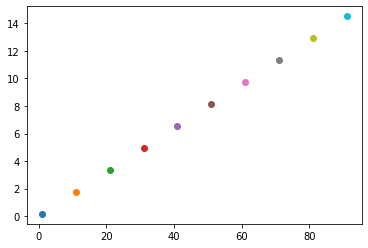

In [37]:
mean = 50
std = 5000

for i in range(1, 100, 10):

    A = ((i - mean)**2) / (2*(std**2))

    num = math.e ** (-A)
    den = std * math.sqrt(math.pi*2)

    y = (num/den) * (i/mean) * 1e5

    print(y)
    plt.scatter(i, y)

plt.show()

In [44]:
def sampler_function(current_epoch, scale=1e5):

    MEAN = 50
    STD = 5000

    A = ((current_epoch - MEAN)**2) / (2*(STD**2))

    num = math.e ** (-A)
    den = STD * math.sqrt(math.pi*2)

    y = (num/den) * (current_epoch/MEAN) * scale

    return min(y, 1.0)

In [45]:
def schedule_sampler(original_target, generated_target, sampler_chance=0.1):

    new_target = []

    for batch in range(max(len(original_target), len(generated_target))):

        target = []

        try:

            candidateA = original_target[batch]
        
        except IndexError:

            new_target.append(generated_target[batch])
            continue

        try:
            candidateB = generated_target[batch]

        except IndexError:

            new_target.append(original_target[batch])
            continue

        for item in range(max(len(candidateA), len(candidateB))):

            if torch.rand((1,)) < sampler_chance:

                try:

                    target.append(candidateB[item])

                except IndexError:

                    target.append(candidateA[item])

            else:

                try:

                    target.append(candidateA[item])

                except IndexError:

                    target.append(candidateB[item])
        
        new_target.append(target)

    return new_target

In [46]:
for epoch in range(30):

    shuffle(batch_shuffle)

    total_loss = 0.0

    for batch in range(0, len(input_texts), BATCH_SIZE):

        model.zero_grad()

        current_batch = batch_shuffle[batch:min(len(input_texts)-1, batch+BATCH_SIZE)]

        input_text, target_text = [], []

        for i in range(len(current_batch)):

            input_text.append(input_texts[current_batch[i]])
            target_text.append(target_texts[current_batch[i]])

        input, real_input_length = model.preprocess_dialogue(input_text, dataset.english_dictionary)
        target, target_length = model.preprocess_target(target_text, dataset.japanese_dictionary)

        encoder_vectors = model.embedding(input) + math.sqrt(model.d_model)
        decoder_vectors = model.embedding(target) + math.sqrt(model.d_model)

        output = model.forward(encoder_vectors, real_input_length, decoder_vectors)

        target_vector = torch.zeros_like(output).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

        cost1 = loss(output[:, :66], target_vector[:, :66])

        #new_target = schedule_sampler(target_vector, output.detach())
        generated_target, _ = model.talk2me(output[:, :66].argmax(-1))
        sampler_chance = sampler_function(epoch, scale=1e4)
        new_target = schedule_sampler(target_text, generated_target, sampler_chance)
        new_target, target_length = model.preprocess_target(new_target, dataset.japanese_dictionary)

        decoder_vectors = model.embedding(new_target) + math.sqrt(model.d_model)

        output = model.forward(encoder_vectors, real_input_length, decoder_vectors)

        target_vector = torch.zeros_like(output).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

        cost2 = loss(output[:, :66], target_vector[:, :66])

        #generated_text, possibilities = model.generate_sentences(input_text)
        #target, target_sizes = model.preprocess_target(target_text, dataset.japanese_dictionary)
        #target_vector = torch.zeros_like(possibilities).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

        # Sampling the 5 highest plausible choices to use as labels
        # Though this doesn't seem to make much sense.
        # Best to simply try to predict the next word/sentence (GPT-2 Pre-Training)

        #_, true_possibilities = torch.sort(possibilities, dim=-1, descending=True)

        #random_idx = torch.randint(0, 5, size=(1,))

        #true_possibilities = true_possibilities[:, random_idx.item()]
        #true_possibilities = true_possibilities[:, -1]

        #cost = loss(possibilities, true_possibilities)

        #cost2 = loss(possibilities[:, :66], target[:, :66])

        total_cost = cost1 + (cost2 * (epoch/100))

        total_cost.backward()

        total_loss += total_cost

        grads = torch.mean(model.encoder[0].attention_heads[0].create_queries.weight.grad)

        optim.step()

        iters += 1

        if iters % 10 == 0:

            print(f"Current Iteration: {iters}\tSampler chance: {sampler_chance}")
            print(f"Last Loss: {total_cost.item()}\tBatch Loss: {total_loss/iters}")
            print(f"Gradients Average: {grads}")
            print(f"Generating Text...")

            model.zero_grad()

            generated_text, possibilities = model.generate_sentences(input_text)

            target_vector = torch.zeros_like(possibilities).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

            cost = loss(possibilities[:, :66], target_vector[:, :66])
            cost.backward()

            optim.step()

            generated_text, _ = model.talk2me(generated_text)

            print(f"Evaluation Loss: {cost.item()}")
            print(generated_text)

Current Iteration: 10	Sampler chance: 0.04787095866249852
Last Loss: 2.9649741649627686	Batch Loss: 0.2964974343776703
Gradients Average: 0.00011130960774607956
Generating Text...
Evaluation Loss: 2.997438907623291
['大まか正字名名字犬名犬名ポー正犬らト歌犬めそ字字大犬犬犬で大犬正犬ト名正小大字大正羨犬正歌名こ名ー歌大そ名犬字名字正字字まー名正大数こ名犬大ま犬よト名ら大字ら字字そトトト名ら字トそ犬らをー名字大ら正犬大こ正言字大トー字名正犬字字そ小名大かー名前字名ト正字名ト赤正正ー犬サそそ名大ト羨名こ字骨名名正か羨大犬かスー字こ正大正ー漢名そ大ト漢羨正をそポ字字まー大生大正らそ正正も正らー名小', '大まか正字名名字犬名犬名ポー正犬らト歌犬めそ字字大犬犬犬で大犬正犬ト名正小大字大正羨犬正歌名こ名ー歌大そ名犬字名字正字字まー名正大数こ名犬大ま犬よト名ら大字ら字字そトトト名ら字トそ犬らをー名字大ら正犬大こ正言字大トー字名正犬字字そ小名大かー名前字名ト正字名ト赤正正ー犬サそそ名大ト羨名こ字骨名名正か羨大犬かスー字こ正大正ー漢名そ大ト漢羨正をそポ字字まー大生大正らそ正正も正らー名小', '大まか正字名名字犬名犬名ポー正犬らト歌犬めそ字字大犬犬犬で大犬正犬ト名正小大字大正羨犬正歌名こ名ー歌大そ名犬字名字正字字まー名正大数こ名犬大ま犬よト名ら大字ら字字そトトト名ら字トそ犬らをー名字大ら正犬大こ正言字大トー字名正犬字字そ小名大かー名前字名ト正字名ト赤正正ー犬サそそ名大ト羨名こ字骨名名正か羨大犬かスー字こ正大正ー漢名そ大ト漢羨正をそポ字字まー大生大正らそ正正も正らー名小']
Current Iteration: 20	Sampler chance: 0.09574244007729277
Last Loss: 2.787767171859741	Batch Loss: 0.27874070405960083
Gradients Average: 2.9116831683495548e-06
Generating Text...
Evaluation Loss: 2.862

# Next Steps: Generative Adversarial Networks

## We can obtain an AI capable of detecting AI-generated texts, while also making an AI capable of generating realistic texts


**TEXT ----> WERNICKE AREA: PROCESS INFORMATION (What does it mean?)**

**WERNICKE ------> ASSOCIATIVE CORTEX(TEMPORAL + PARIETAL?) -----> BROCA AREA: GENERATES NEW(?) INFORMATION ---> MOTOR CORTEX (PRECENTRAL GYRUS)**


*Question: Can she detect metaphores, implicit messages, sense of humour, poetry? Such things aren't as simple as "Word ---> Meaning", afterall.*